In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import pickle
from tensorflow.keras.applications.vgg19 import decode_predictions, preprocess_input, VGG19

# The Model

We decided to use the VGG19 model trained on imagenet.

In [2]:
DATA_DIR = "data/ILSVRC2012_img_val"
GROUND_TRUTH = "data/ground_truth.txt"
PICKLE_DIR = "pickles"
MAPPING_DATA = "data/devkit/data/map_clsloc.txt"
file_names = os.listdir(DATA_DIR)
READ_FROM_PICKLE = True
file_names.sort()

In [3]:
def read_images(file_names, data_dir):
    images = []
    i = 0
    for file_name in file_names:
        i += 1
        if i % 1000 == 0:
            print("Read {} images".format(i))
        file_path = os.path.join(data_dir, file_name)
        image = Image.open(file_path)
        image = image.resize((224, 224))
        image = np.array(image)
        if len(image.shape) != 3:
            image = np.stack((image,)*3, axis=-1)
        if image.shape[2] == 4:
            image = image[:,:,:3]
        # image = preprocess_input(image)
        images.append(image)
    return images

if not READ_FROM_PICKLE:
    images = read_images(file_names, DATA_DIR)
    # for i in range(len(images)):
    #     # make sure each image has 3 channels
    #     if len(images[i].shape) != 3:
    #         images[i] = np.stack((images[i],)*3, axis=-1)
    #     if images[i].shape[2] == 4:
    #         images[i] = images[i][:,:,:3]
    images = np.array(images)
    with open(os.path.join(PICKLE_DIR, "images.pickle"), "wb") as f:
        pickle.dump(images, f)
else:
    with open(os.path.join(PICKLE_DIR, "images.pickle"), "rb") as f:
        images = pickle.load(f)

## Remapping the Labels

In [4]:
labels = pd.read_csv(GROUND_TRUTH, sep=" ", header=None).to_numpy()
mapping = pd.read_csv(MAPPING_DATA, delimiter=" ", header=None, names=['code', 'id', 'name'])
labels_df = pd.DataFrame(labels)
labels_df.columns = ["id"]
merged_df = pd.merge(mapping, labels_df, on='id', how="right")
vgg_output_labels = decode_predictions(np.identity(1000), top=1)

processed_labels = []
i = 0
for label in vgg_output_labels:
    new_label = []
    new_label.append(label[0][0])
    new_label.append(label[0][1])
    new_label.append(label[0][2])
    new_label.append(i)
    processed_labels.append(new_label)
    i+=1

vgg_output_labels = pd.DataFrame(processed_labels, columns=["code", "name", "score", "vgg_index"])
merged_df = pd.merge(vgg_output_labels, merged_df, on="code", how="right")

labels = merged_df["vgg_index"].to_numpy()

In [5]:
input = tf.keras.Input(shape=(224, 224, 3))

x = tf.cast(input, tf.float32)
x = tf.keras.applications.vgg19.preprocess_input(x)

vgg_model = tf.keras.applications.VGG19(weights='imagenet', input_tensor=x)

vgg_model.summary()


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-23 15:18:22.596073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-23 15:18:22.597962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                             

# Validation Test:

In [13]:
batch_size = 1000
num_batches = len(images) // batch_size

# Make predictions on each batch separately
predictions = []
for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    batch_images = images[start:end]
    batch_predictions = vgg_model.predict(batch_images)
    predictions.append(batch_predictions)

# Concatenate the predictions from all batches into a single array
predictions = np.concatenate(predictions)

32/32 [==============================] - 4s 130ms/step


In [14]:
predictions = np.argmax(predictions, axis=1)

In [15]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(labels, predictions)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.65888


We are getting top 1 accuracy of around 66%.

# Classifying a couple examples:

In [16]:
y_hat = vgg_model.predict(images[:15])

2023-03-21 22:24:03.520123: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-21 22:24:03.520146: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-21 22:24:04.432255: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-21 22:24:04.432280: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

1/1 [==============================] - 4s 4s/step


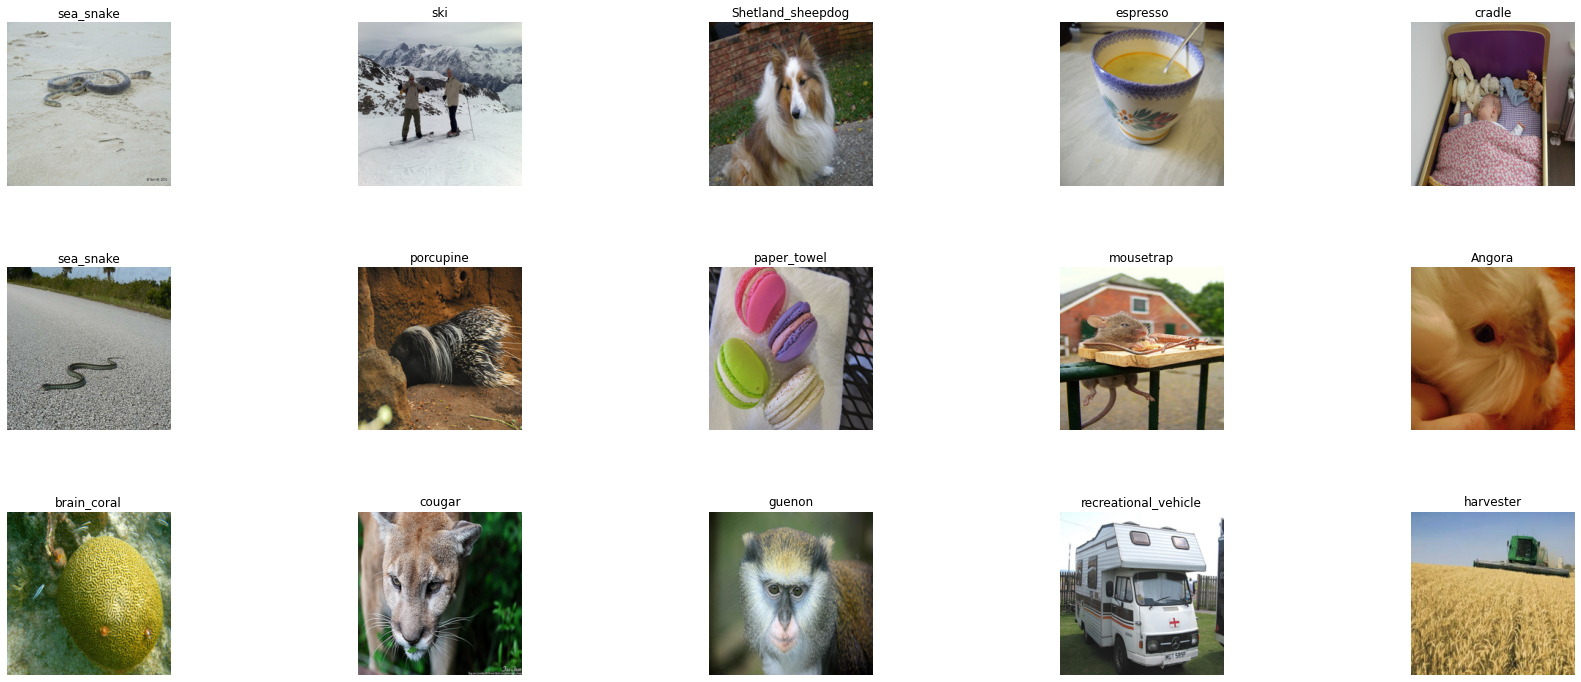

In [17]:
# GENERATED BY GPT
fig, axs = plt.subplots(3, 5, figsize=(30, 12), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
for i in range(15):
    ax = axs[i//5, i%5]
    ax.imshow(images[i])
    ax.set_title(decode_predictions(y_hat, top=1)[i][0][1])
    ax.axis("off")
plt.show()


These classifications seem to be working decently, obviously some are wrong but the model itself seems to be classifying to some degree as intended.

# Chosing a Filter


conv5_1 unit 474

In [6]:
for layer in vgg_model.layers:
    vgg_model.trainable = False

layer_name = 'block5_conv1'

## Finding an Image that maximally excites our filter 

In [71]:
def generate_pattern(layer_name, filter_index, size=224):
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = vgg_model.get_layer(layer_name).output
    # Isolate the output 
    new_model = tf.keras.models.Model(inputs=vgg_model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')
    I = preprocess_input(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1
    for i in range(100):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 
            loss = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(loss, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


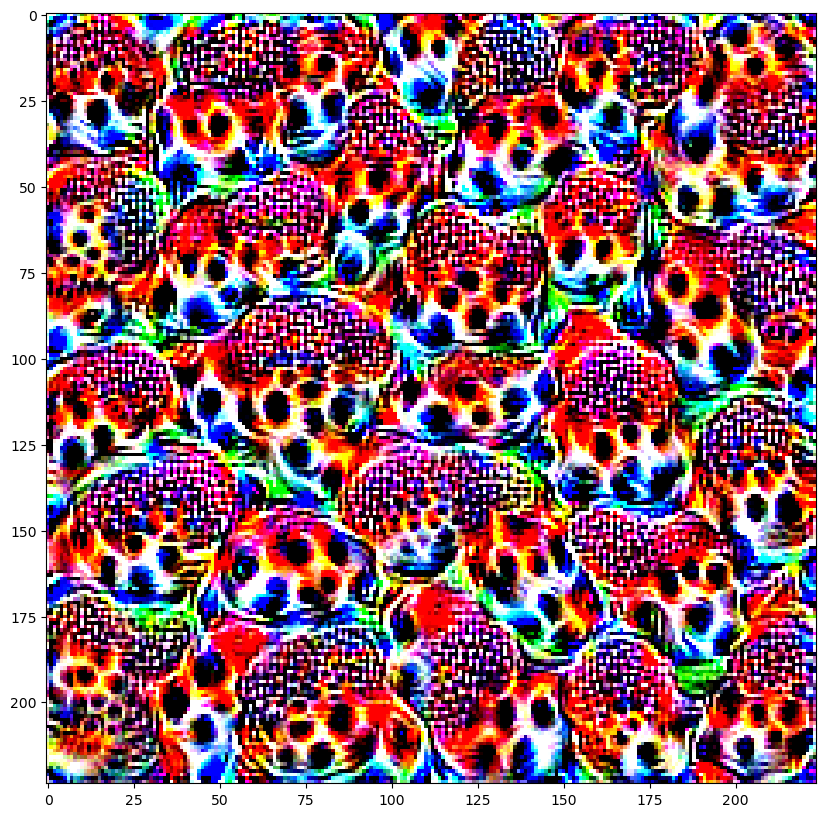

In [48]:
output = generate_pattern(layer_name, 474)
plt.figure(figsize=(10, 10))
plt.imshow(output[0] / 60)

## Finding classes that maximally excite the filter

In [10]:
new_model = tf.keras.models.Model(inputs=vgg_model.input, outputs=vgg_model.get_layer(layer_name).output)

batch_size = 1000
num_batches = len(images) // batch_size

activations = []
for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    batch_images = images[start:end]
    batch_predictions = new_model.predict(batch_images)
    activations.append(batch_predictions)

2023-03-23 15:19:31.090743: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-23 15:19:31.187884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/32 [========================>.....] - ETA: 1s

KeyboardInterrupt: 

In [ ]:
activations = np.concatenate(activations)

In [ ]:
filter_activations = activations[:, :, :, 474]
#  means across each image
filter_activations = np.mean(filter_activations, axis=(1, 2))

In [ ]:
class_activations = {
    # class_index: activations
}

for i in range(len(filter_activations)):
    class_index = labels[i]
    if class_index not in class_activations:
        class_activations[class_index] = []
    class_activations[class_index].append(filter_activations[i])
class_activations = {k: np.mean(v) for k, v in class_activations.items()}
sorted_activations = sorted(class_activations.items(), key=lambda x: x[1], reverse=True)

In [ ]:
sorted_activations[9]

(560, 128.75499)

In [ ]:
# list out the top 10 classes with their class names:
print("Top 10 classes excited by our filter with the mean of the activations:")
for i in range(10):
    class_index = sorted_activations[i][0]
    class_activation_mean = sorted_activations[i][1]
    class_name = merged_df[merged_df["vgg_index"] == class_index]["name_x"].values[0]
    print("{}: {} ({})".format(i+1, class_name, class_activation_mean))

Top 10 classes excited by our filter with the mean of the activations:
1: jaguar (330.4889831542969)
2: leopard (328.6689758300781)
3: dalmatian (276.73956298828125)
4: cheetah (224.08370971679688)
5: agaric (172.3334503173828)
6: snow_leopard (163.4036865234375)
7: honeycomb (134.05979919433594)
8: disk_brake (133.68960571289062)
9: mushroom (133.3890838623047)
10: football_helmet (128.75498962402344)


We hypothesize that this filter is a spotted animal detector, in that the top 4 maximally exciting classes are all spotted animals (3 cats and a type of dog), but some of of the other classes in the top 10 are not animals, but spotted objects (such as agaric (a type of spotted fungus), mushroom, and honeycomb). Also, its woorht mentioning that football helmet is an outlier in that it does not contain spots but it is the 10th highest exciting class, but we can't ber sure why as of now, but, maybe, investigating further in the lab will give us a better idea. 

# Circuits


In [11]:
# get filter

multi_channel_filter = vgg_model.get_layer(layer_name).get_weights()[0][:, :, :, 474] 

In [12]:
# get the l2 norm of each channel
l2_norms = np.linalg.norm(multi_channel_filter, axis=(0, 1))

In [13]:
indexes = [i for i in range(512)]
# sorting l2 norms and indexes at same time so we can preserve the order and get the indexes
l2_norms, indexes = zip(*sorted(zip(l2_norms, indexes), reverse=True))

In [14]:
top_6 = indexes[:6]

In [15]:
top_6

(109, 336, 54, 316, 405, 124)

In [16]:
multi_channel_filter[:,:,336]

array([[-0.01250291,  0.0375888 , -0.00859504],
       [ 0.02035537,  0.11474656,  0.02728442],
       [-0.00707084,  0.02692899,  0.00122255]], dtype=float32)

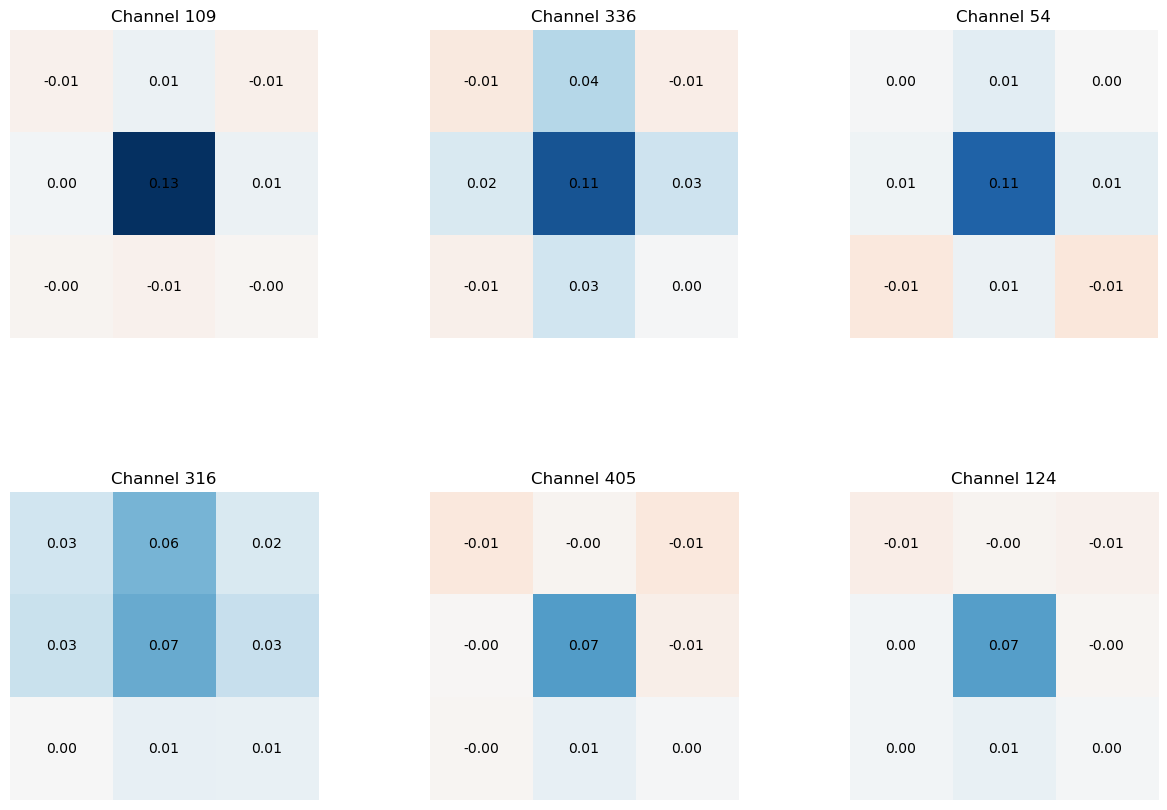

In [17]:
# Plotting the top 6 channels with numerical values in center
fig, axs = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
for i in range(6):
    ax = axs[i//3, i%3]
    cmap = plt.cm.get_cmap('RdBu').copy()
    cmap.set_bad(color='white')
    im = ax.imshow(multi_channel_filter[:, :, top_6[i]], cmap=cmap, vmin=-np.max(multi_channel_filter), vmax=np.max(multi_channel_filter))
    ax.set_title("Channel {}".format(top_6[i]))
    ax.axis("off")
    for j in range(multi_channel_filter.shape[0]):
        for k in range(multi_channel_filter.shape[1]):
            text = ax.text(k, j, "{:.2f}".format(multi_channel_filter[j,k,top_6[i]]),
                           ha="center", va="center", color="black")


From the visualization of the top 6 filters by euclidian norm, we can see that all of these filters are fairly similar in nature and seem to have their highsst value in the middle and relatively smaller values for the non-center coefficients. However, these other values do differ somewhat for these filters, meaning they aren't all the same category. Channel 109 i

In [49]:
outputs = []
for n in top_6:
    outputs.append(generate_pattern('block4_conv4', n))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


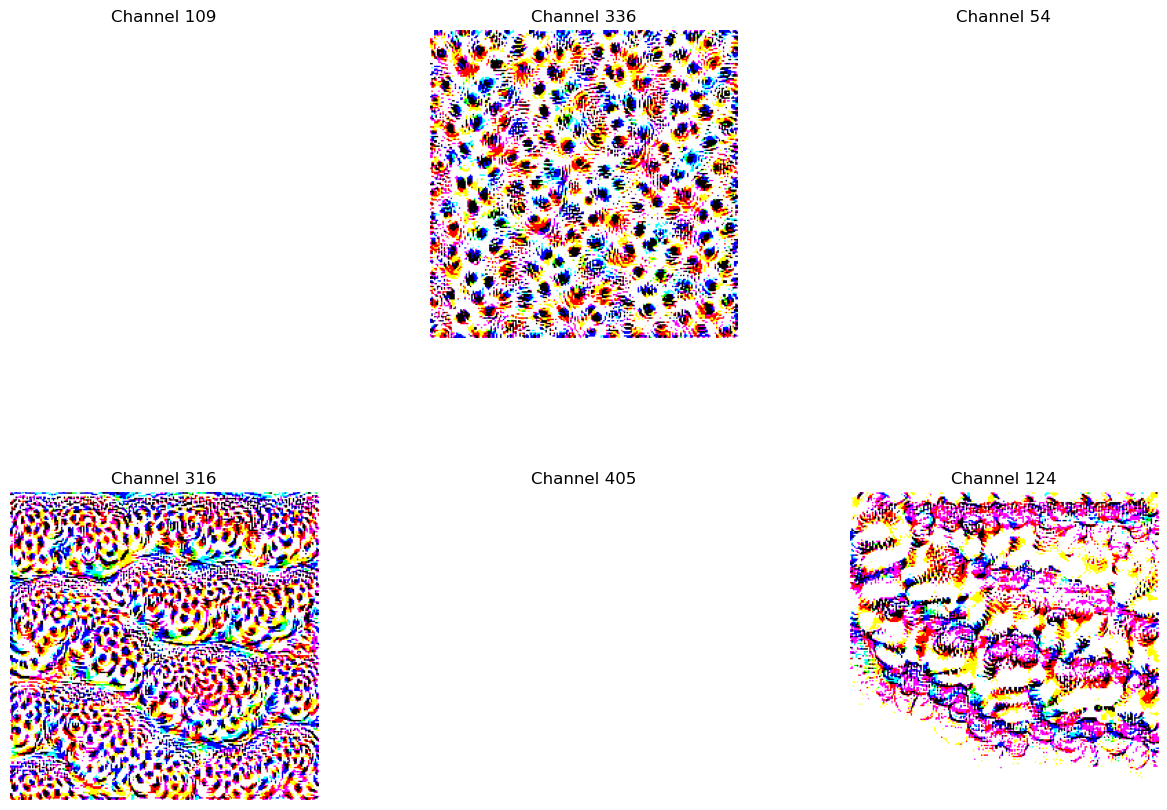

In [50]:
# plot each of the 6 outputs
fig, axs = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
for i in range(6):
    ax = axs[i//3, i%3]
    ax.imshow(outputs[i][0] )
    ax.set_title("Channel {}".format(top_6[i]))
    ax.axis("off")

In [110]:
top_filters = [336, 316, 56, 268, 447, 276, 302,368]

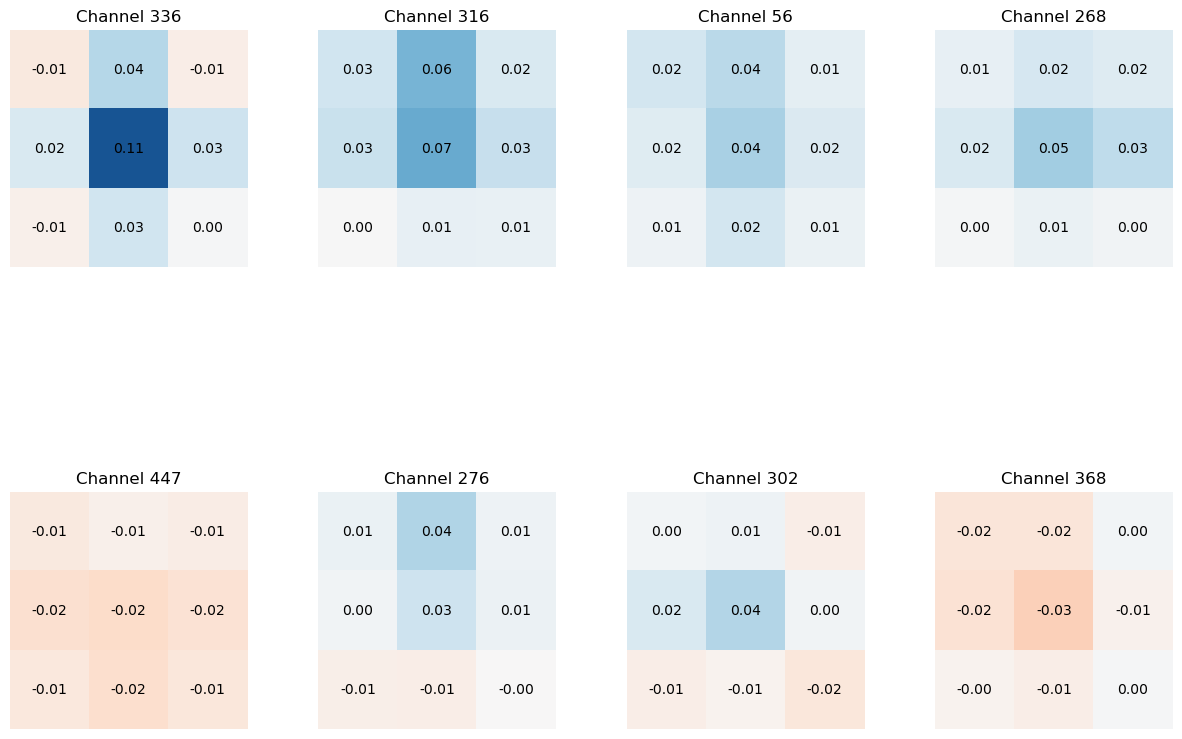

In [111]:
# Plotting the top 6 channels with numerical values in center
fig, axs = plt.subplots(2, 4, figsize=(15, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
for i in range(8):
    ax = axs[i//4, i%4]
    cmap = plt.cm.get_cmap('RdBu').copy()
    cmap.set_bad(color='white')
    im = ax.imshow(multi_channel_filter[:, :, top_filters[i]], cmap=cmap, vmin=-np.max(multi_channel_filter), vmax=np.max(multi_channel_filter))
    ax.set_title("Channel {}".format(top_filters[i]))
    ax.axis("off")
    for j in range(multi_channel_filter.shape[0]):
        for k in range(multi_channel_filter.shape[1]):
            text = ax.text(k, j, "{:.2f}".format(multi_channel_filter[j,k,top_filters[i]]),
                           ha="center", va="center", color="black")

In [113]:
# run gradient ascent on each of the 6 filters
outputs = []
for n in top_filters:
    outputs.append(generate_pattern('block4_conv4', n))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


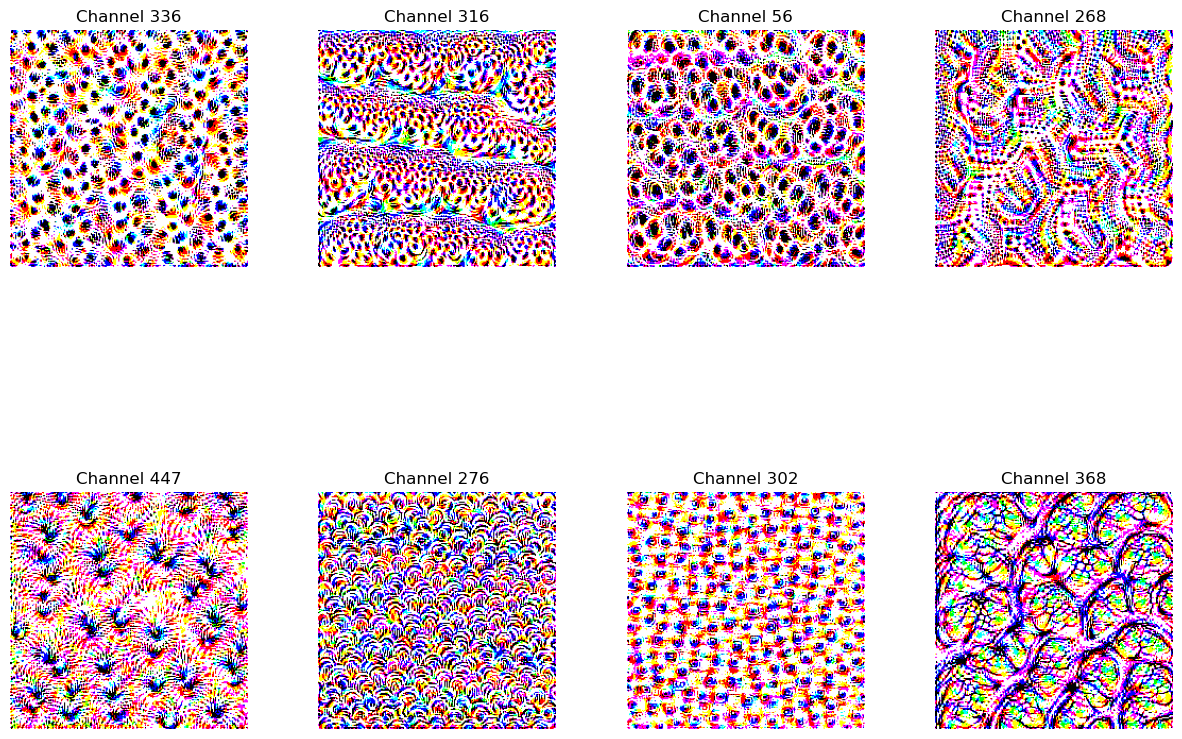

In [114]:
# plot each of the outputs
fig, axs = plt.subplots(2, 4, figsize=(15, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
for i in range(8): 
    ax = axs[i//4, i%4]
    ax.imshow(outputs[i][0] )
    ax.set_title("Channel {}".format(top_filters[i]))
    ax.axis("off")